In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/autotrophy/'
m_fname = path.join(model_dir, 'glucose_auto_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_auto_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
lam.print_model()

Metabolites:
         NC  NOSC  internal                                               note
C_red     1   0.0         1            reduced C, 1 C of intracellular glucose
C_ox      1   4.0         0                      oxidized carbon carrier "CO2"
E_ox      1   0.0         0  oxidized e- donor/acceptor, O2, has fictional ...
E_red     1  -4.0         0  reduced donor/acceptor, 2 H2O, NC = 1 for bala...
EC       20   0.0         1          Oxidized two e- carrier with 20 carbons. 
ECH      20  -0.1         1  Reduced 2e- carrier, 20*-0.1 => 2 more e- than...
ADP      10   0.0         1                                                ADP
ATP      10   0.0         1                                                ATP
biomass   1   0.0         0                   Everything per C, default ZC = 0
Stoichiometries:
                   C_red  C_ox  E_ox  E_red   EC  ECH   ADP   ATP  biomass  \
process                                                                      
oxidation            0.0

In [3]:
# Do a quick run of the model to make sure it is feasible
lambda_max, opt_p = lam.maximize_lambda(phi_o=0.4)
lambda_max

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


0.1799999999215881

In [6]:
# Run the model at various fixed lambda_hr values to calculate optimal phi values
p = lam.max_anabolic_rate_problem(max_lambda_hr=1e-5, phi_o=0.4)

phis = []
lambdas_actual = []
max_lambdas = np.logspace(-3, -0.5, 50)

for max_lam in max_lambdas:
    p.param_dict['max_lambda_hr'].value = max_lam
    res = p.solve()
    if p.status in ("infeasible", "unbounded"):
        phis.append(np.zeros(lam.S_df.index.size + 1).tolist())
        lambdas_actual.append(0)
        continue

    # Have an optimum
    phis.append(p.var_dict['phis'].value.tolist() + [p.param_dict['phi_o'].value])    
    lambdas_actual.append(p.value)

colnames = lam.S_df.index.values.tolist() + ['other']
phi_df = pd.DataFrame(phis, columns=colnames)
phi_df['max_lambda_hr'] = max_lambdas
phi_df['actual_lambda_hr'] = lambdas_actual
phi_df = phi_df.set_index('max_lambda_hr')
phi_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,oxidation,reduction,anabolism,cyclic_flow,ATP_homeostasis,redox_homeostasis,other,actual_lambda_hr
max_lambda_hr,,,,,,,,
0.001000,0.001270,0.000556,0.000556,0.298298,0.298369,0.000952,0.4,0.001000
0.001125,0.001425,0.000625,0.000625,0.298085,0.298166,0.001074,0.4,0.001125
0.001265,0.001598,0.000703,0.000703,0.297846,0.297938,0.001213,0.4,0.001265
0.001423,0.001792,0.000790,0.000790,0.297577,0.297682,0.001369,0.4,0.001423
0.001600,0.002009,0.000889,0.000889,0.297274,0.297393,0.001546,0.4,0.001600


Text(0, 0.5, '$\\phi$')

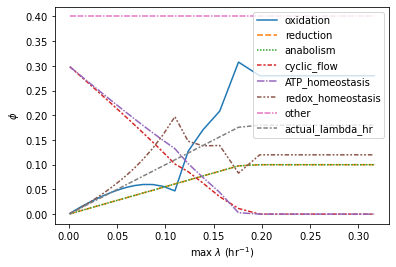

In [7]:
mask = phi_df['actual_lambda_hr'] > 0
sns.lineplot(data=phi_df[mask])
plt.xlabel(r'max $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   

In [8]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_red", "ox_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 1000], [0.2, 2], [10, 1000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

# Store the results in a dictionary for making a dataframe
res_dict = dict(ZCB=[], S6=[], phi_O=[], lambda_max=[], m_red=[],
                ox_ATP_per_e=[], m_ATP_homeostasis=[])
for p in list(lam.processes) + ['other']:
    res_dict['{0}_phi'.format(p)] = []
    res_dict['{0}_flux'.format(p)] = []

for phi_o, s6, m_red, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_red)
    lam.set_process_mass('cyclic_flow', m_homeo)
    lam.set_ATP_yield('oxidation', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    res_dict['ZCB'].append(lam.ZCB)
    res_dict['S6'].append(s6)
    res_dict['phi_O'].append(phi_o)
    res_dict['m_red'].append(m_red)
    res_dict['ox_ATP_per_e'].append(atp_per_e)
    res_dict['m_ATP_homeostasis'].append(m_homeo)

    if max_lam == 0:
        res_dict['lambda_max'].append(0)
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(np.NaN)
            res_dict['{0}_flux'.format(process)].append(np.NaN)
        res_dict['other_phi'].append(np.NaN)
        res_dict['other_flux'].append(np.NaN)
    else:
        res_dict['lambda_max'].append(max_lam)

        phis = opt_prob.var_dict['phis'].value.copy()
        js = 3600*phis*lam.kcat_s/lam.m_Da
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(phis[k])
            res_dict['{0}_flux'.format(process)].append(js[k])
        res_dict['other_phi'].append(phis[-1])
        res_dict['other_flux'].append(np.NaN)

res_df = pd.DataFrame(res_dict)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,ZCB,S6,phi_O,lambda_max,m_red,ox_ATP_per_e,m_ATP_homeostasis,oxidation_phi,oxidation_flux,reduction_phi,...,anabolism_phi,anabolism_flux,cyclic_flow_phi,cyclic_flow_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,redox_homeostasis_phi,redox_homeostasis_flux,other_phi,other_flux
0,0.742125,-0.371063,0.432122,0.081786,822.127732,0.639550,45.346313,1.510243e-08,2.718437e-08,0.373547,...,0.045437,0.081786,8.679447e-04,3.445265e-03,7.867712e-10,1.416188e-09,0.148027,0.266448,0.148027,NaN
1,0.742125,-0.371063,0.313040,0.098936,822.127732,0.639550,45.346313,1.525088e-08,2.745158e-08,0.451878,...,0.054964,0.098936,1.049949e-03,4.167720e-03,7.937684e-10,1.428783e-09,0.179067,0.322321,0.179067,NaN
2,-0.982989,0.491494,0.432122,0.071963,822.127732,0.639550,45.346313,1.866689e-01,3.360039e-01,0.328682,...,0.039979,0.071963,4.568714e-09,1.813529e-08,3.480855e-09,6.265539e-09,0.012548,0.022586,0.012548,NaN
3,0.742125,-0.371063,0.432122,0.125433,387.220650,0.639550,45.346313,3.777052e-08,6.798694e-08,0.269836,...,0.069685,0.125433,1.331153e-03,5.283949e-03,1.304063e-09,2.347314e-09,0.227026,0.408646,0.227026,NaN
4,0.742125,-0.371063,0.432122,0.081911,822.127732,1.731225,45.346313,2.621561e-03,4.718810e-03,0.374119,...,0.045506,0.081911,4.430889e-09,1.758820e-08,1.451041e-09,2.611874e-09,0.145632,0.262137,0.145632,NaN


In [9]:
ps.set_results(res_df.lambda_max.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.087522  0.043823
S6                 0.090622  0.055468
m_red              0.756989  0.385518
ox_ATP_per_e       0.016479  0.015603
m_ATP_homeostasis  0.001047  0.001340
                         S1   S1_conf
phi_o              0.122032  0.131231
S6                 0.019355  0.125195
m_red              0.791143  0.275026
ox_ATP_per_e      -0.016405  0.031387
m_ATP_homeostasis -0.017255  0.022437
                                         S2   S2_conf
(phi_o, S6)                       -0.093561  0.198313
(phi_o, m_red)                    -0.032881  0.250107
(phi_o, ox_ATP_per_e)             -0.088280  0.193081
(phi_o, m_ATP_homeostasis)        -0.091893  0.193801
(S6, m_red)                        0.065918  0.266839
(S6, ox_ATP_per_e)                 0.015653  0.197582
(S6, m_ATP_homeostasis)            0.007397  0.196771
(m_red, ox_ATP_per_e)             -0.168301  0.545546
(m_red, m_ATP_homeostasis)        -0.199681  0.508793
(ox_

{'names': ['phi_o', 'S6', 'm_red', 'ox_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 1000], [0.2, 2], [10, 1000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='m_red', ylabel='lambda_max'>

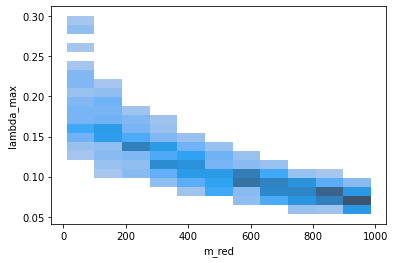

In [10]:
sns.histplot(data=res_df, y='lambda_max', x='m_red', legend=False)

<AxesSubplot: xlabel='m_ATP_homeostasis', ylabel='lambda_max'>

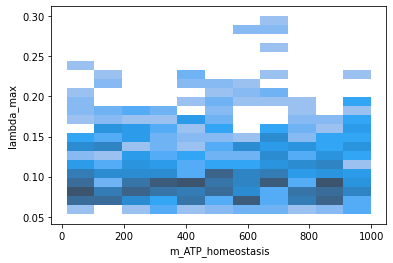

In [11]:
sns.histplot(data=res_df, y='lambda_max', x='m_ATP_homeostasis', legend=False)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


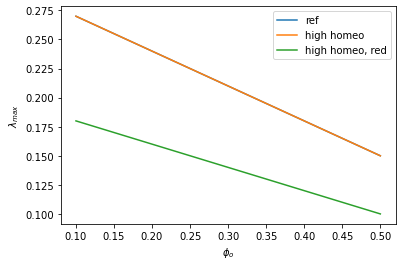

In [12]:
ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('cyclic_flow', 400) # 4x baseline

high_homeo_red_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_red_lam.set_process_mass('cyclic_flow', 400) # 4x baseline
high_homeo_red_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
ref_lambdas = [ref_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_red_lambdas = [high_homeo_red_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_red_lambdas, label='high homeo, red')
plt.legend()
plt.xlabel(r'$\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [15]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.3, 0.501, 0.1)
homeo_costs = np.logspace(1, 3, 3)
ox_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

# Load a model, will copy it for each run so we know we are always modifying
# same the baseline but don't need to read a file in the inner loop
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], ox_cost=[], ox_ATP_per_e=[])

phi_names = ['phi_{0}'.format(p) for p in lmm.processes]
j_names = ['j_{0}'.format(p) for p in lmm.processes]
res_dict.update({k: [] for k in phi_names})
res_dict.update({k: [] for k in j_names})

for z in ZCBs:
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for ox_cost in ox_costs:
                for atp_per_e in ATP_per_es:
                    ref_lam = lmm.copy()
                    ref_lam.set_ZCB(z)
                    ref_lam.set_process_mass('oxidation', ox_cost)
                    ref_lam.set_process_mass('cyclic_flow', ox_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_process_mass('redox_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, opt_p = ref_lam.maximize_lambda(phi_o=phi_o)
                    res_dict['ZCB'].append(z)
                    res_dict['phi_o'].append(phi_o)
                    res_dict['homeo_cost'].append(homeo_cost)
                    res_dict['lambda_max'].append(m)
                    res_dict['S6'].append(ref_lam.get_S6())
                    res_dict['ox_cost'].append(ox_cost)
                    res_dict['ox_ATP_per_e'].append(atp_per_e)

                    # get phis and fluxes                    
                    phis = opt_p.var_dict['phis'].value
                    if m == 0:
                        phis = np.zeros(lmm.n_processes)
                    ks = opt_p.param_dict['ks'].value
                    ms = opt_p.param_dict['ms'].value
                    js = phis*ks/ms
                    for name, phi, j in zip(lmm.processes, phis, js):
                        res_dict['phi_{0}'.format(name)].append(phi)
                        res_dict['j_{0}'.format(name)].append(j)
res_df = pd.DataFrame(res_dict)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


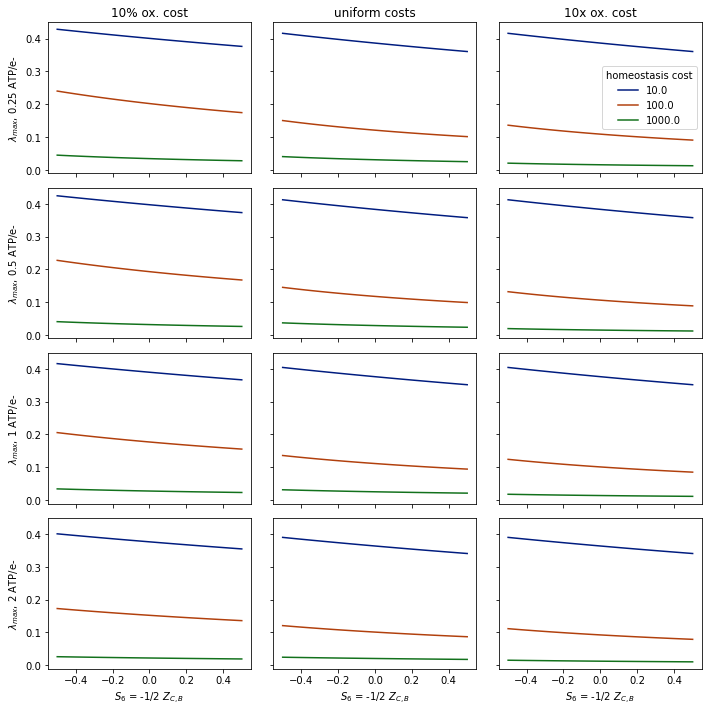

In [16]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey=True)

titles = '10% ox. cost,uniform costs,10x ox. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, ox_cost in enumerate(ox_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.ox_cost == ox_cost, res_df.phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.ox_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_max', hue='homeo_cost', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

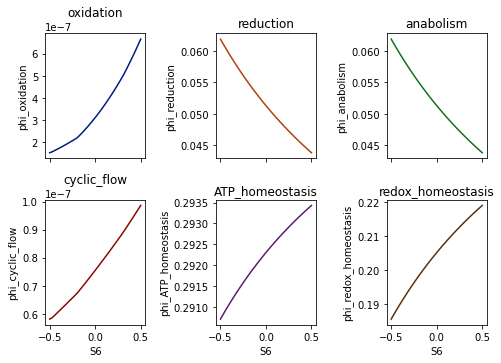

In [14]:
mask = np.logical_and(res_df.ox_cost == 1000.0, res_df.phi_o == 0.4)
mask = np.logical_and(mask, res_df.ox_ATP_per_e == 2.0)
mask = np.logical_and(mask, res_df.homeo_cost == 100.0)

fig, axs = plt.subplots(figsize=(7, 5), nrows=2, ncols=3, sharex=True, sharey=False)
flat_axs = axs.flatten()
pal = sns.color_palette('dark', ref_lam.n_processes)
for i, p in enumerate(ref_lam.processes):
    plt.sca(flat_axs[i])
    phi_name = 'phi_{0}'.format(p)
    sns.lineplot(data=res_df[mask], y=phi_name, x='S6', color=pal[i])
    plt.title(p)


plt.tight_layout()

In [15]:
res_df.phi_o.describe()

count    4428.000000
mean        0.400000
std         0.081659
min         0.300000
25%         0.300000
50%         0.400000
75%         0.500000
max         0.500000
Name: phi_o, dtype: float64

In [16]:
res_df.head()

,ZCB,phi_o,homeo_cost,lambda_max,S6,ox_cost,ox_ATP_per_e,phi_oxidation,phi_reduction,phi_anabolism,phi_cyclic_flow,phi_ATP_homeostasis,phi_redox_homeostasis
0,-1.0,0.3,10.0,0.439024,0.5,10.0,0.25,0.121951,0.243902,0.243902,9.990726e-07,0.090244,4.261961e-07
1,-1.0,0.3,10.0,0.435232,0.5,10.0,0.50,0.120897,0.241796,0.241796,9.485087e-07,0.095510,4.086895e-07
2,-1.0,0.3,10.0,0.427843,0.5,10.0,1.00,0.118845,0.237691,0.237691,8.607370e-07,0.105773,3.757435e-07
3,-1.0,0.3,10.0,0.413793,0.5,10.0,2.00,0.114942,0.229885,0.229885,7.247944e-07,0.125287,3.190628e-07
4,-1.0,0.3,10.0,0.420696,0.5,100.0,0.25,0.000005,0.233720,0.233720,4.408739e-06,0.115692,1.168594e-01
